In [30]:
import spacy
import numpy
import os
import pathlib
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.layers import TimeDistributed
from keras.models import Sequential, model_from_json
from keras.optimizers import Adam
from spacy.compat import pickle
import matplotlib.pyplot as plt


pt_br_model = 'pt_wikipedia_md'


class SentimentAnalyser(object):
    @classmethod
    def load(cls, path, nlp, max_length=100):
        """
        Loads the language model file.
        """
        with (path / 'config.json').open() as file_:
            model = model_from_json(file_.read())
        with (path / 'model').open('rb') as file_:
            lstm_weights = pickle.load(file_)
        embeddings = get_embeddings(nlp.vocab)
        model.set_weights([embeddings] + lstm_weights)
        return cls(model, max_length=max_length)

    def __init__(self, model, max_length=100):
        self._model = model
        self.max_length = max_length

    def __call__(self, doc):
        X = get_features([doc], self.max_length)
        y = self._model.predict(X)
        self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=1000, n_threads=2):
        for doc in docs:
            Xs = get_features([doc], self.max_length)
            ys = self._model.predict(Xs)
            for doc, label in zip([doc], ys):
                doc.sentiment += label
            yield doc

    def set_sentiment(self, doc, y):
        doc.sentiment = float(y[0])


def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        sentences.append(doc)
        labels.append(y)
    return sentences, numpy.asarray(labels, dtype='int32')


def get_features(docs: list, max_length):
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs


def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False,
            weights=[embeddings]
        )
    )
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Dropout(settings['dropout']))
    model.add(Bidirectional(LSTM(shape['nr_hidden'], recurrent_dropout=settings['dropout'], dropout=settings['dropout'])))
    model.add(Dropout(settings['dropout']))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='mse', metrics=['acc'])
    return model


def get_embeddings(vocab):
    return vocab.vectors.data


def train(train_texts, train_labels, dev_texts, dev_labels,
          lstm_shape, lstm_settings, lstm_optimizer, batch_size=100,
          nb_epoch=5, by_sentence=True):
    print("Loading spaCy")
    nlp = spacy.load(pt_br_model)
    embeddings = get_embeddings(nlp.vocab)
    model = compile_lstm(embeddings, lstm_shape, lstm_settings)

    print("Parsing texts...")
    train_docs = list(nlp.pipe(train_texts))
    dev_docs = list(nlp.pipe(dev_texts))
    print("Starting get_labelled_sentences()")
    if by_sentence:
        train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
        dev_docs, dev_labels = get_labelled_sentences(dev_docs, dev_labels)

    train_X = get_features(train_docs, lstm_shape['max_length'])
    dev_X = get_features(dev_docs, lstm_shape['max_length'])
    history = model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels), epochs=nb_epoch, batch_size=batch_size, verbose=0)
    print("Model ready")

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    return model


def evaluate(model_dir, texts, labels, max_length=100):
    nlp = spacy.load(pt_br_model)
    nlp.add_pipe(nlp.create_pipe('sentencizer'), first=True)
    nlp.add_pipe(SentimentAnalyser.load(model_dir, nlp, max_length=max_length))
    correct = 0
    i = 0
    for doc in nlp.pipe(texts, batch_size=1000, n_threads=4):
        if doc.sentiment >= 0.5 and bool(labels[i]) is True:
            print(texts[i] + " correctly classified as Good " + str(doc.sentiment))
        elif doc.sentiment >= 0.5 and bool(labels[i]) is False:
            print(texts[i] + " wrongly classified as Good " + str(doc.sentiment))
        elif doc.sentiment < 0.5 and bool(labels[i]) is True:
            print(texts[i] + " wrongly classified as Bad " + str(doc.sentiment))
        elif doc.sentiment < 0.5 and bool(labels[i]) is False:
            print(texts[i] + " correctly classified as Bad " + str(doc.sentiment))
        correct += bool(doc.sentiment >= 0.5) == bool(labels[i])
        i += 1
    return float(correct) / i


train_samples = [
    ('bom', 1),
    ('perfeito', 1),
    ('entrega rápido', 1),
    ('satisfeito', 1),
    ('excelente', 1),
    ('bom qualidade', 1),
    ('excelente', 1),
    ('excelente qualidade', 1),
    ('vale a pena', 1),
    ('melhorou ultimamente', 1),
    ('gostei', 1),
    ('barato', 1),
    ('serviu bem', 1),
    ('feliz', 1),
    ('filho feliz', 1),
    ('esposa gostou', 1),
    ('bom suporte', 1),
    ('ruim', 0),
    ('péssimo', 0),
    ('péssima qualidade', 0),
    ('quebrado', 0),
    ('quebrou', 0),
    ('não gostei', 0),
    ('filho não gostou', 0),
    ('precisa melhorar', 0),
    ('pode melhorar', 0),
    ('demorou', 0),
    ('entrega demorada', 0),
    ('droga', 0),
    ('má qualidade', 0),
    ('caro', 0),
    ('retornei', 0),
    ('não serviu', 0),
    ('ultrapassado', 0),
    ('desapontado', 0),
    ('triste', 0),
    ('não grande coisa', 0),
    ('precisei suporte', 0),
    ('troca', 0),
]

validation_samples = [
    ('boa proposta', 1),
    ('serviu perfeitamente', 1),
    ('acabamento perfeito', 1),
    ('qualidade impressionante', 1),
    ('marca confiança', 1),
    ('querer outro', 1),
    ('não gostei resultado', 0),
    ('deveria melhorar concorrência', 0),
    ('insatisfeito produto', 0),
    ('muito caro', 0),
    ('defeituoso', 0),
    ('esperei muito', 0),
    ('garantia', 0)
]

test_samples = [
    ('Excelente Excelente produto muito bom', 1),
    ('Um ótimo investimento a um preço justo Produto de qualidade para o que se propõe a fazer ou seja para ser utilizada em ambiente doméstico cumpre o que promete e com um preço justo Mas não se engane ela é lenta como furadeira Caso queira furar aço muito espesso ou uma madeira muito dura melhor investir em brocas bem afiadas Como parafusadeira ela é ótima tem um excelente torque Só não entendo o porque na descrição do produto tem 10nm de torque enquanto que no manual indica que tem 8nm Perguntei à demeo o por que disso mas não obtive resposta apesar de terem dito que iriam avaliar isso Utilizo a parafusadeira em pinus e já fiz muita coisa com excelentes resultados', 1),
    ('Bom Parafusadeira boa para trabalhos pequenos uma vez que não utilizei para realizar trabalhos maiores O ponto forte é a bateria que é excelente e mantém a carga por muito tempo Estou utilizando a mais de um mês e ainda não descarregou O ponto fraco é que os bits pontas são fracas e se danificam com facilidade na cabeça dos parafusos No geral é uma boa ferramenta sim vale o preço sem dúvida', 1),
    ('Compro novamente sem medo Relação custo beneficio muito boa faço oficinas com crianças a furadeira é leve de segurar e forte suficiente para as minhas atividades mesmo com adultos A bateria tem boa duração recarrega rápido e diferente do similar concorrente bosch aceita brocas até 10 mm Tem um visual atraente que querendo ou não dá uma sensação de mais qualidade e preocupação com o usuário', 1),
    ('Muito boa Excelente produto Mto forte e de ótima qualidade Só falta um regulagem de torque E tb acho que o modo rápido de colocar brocas peca um pouco Usei ela algumas vezes para furar madeira e na hora de retirar a broca escapa da parafusadeira e a broca fica fincada na madeira Tirando isso a qualidade do produto é excepcional', 1),
    ('Excelente Eu queria somente dizer que o produto é bom Mas essa porra do mercado livre não me deixa ser sucinto Então tenho que escrever um monte de bosta só para encher linguiça ainda tenho 1311 caracteres para escrever Acho que vou ficando por aqui Beijos a todos desta família de consumistas que somos nós Até a próxima avaliação', 1),
    ('Sensacional Comprei para instalar uns gabinetes pesados e pratilheiras de parede e me atendeu mto bem furou a parede igual um queijo produto de qualidade aparenta que vai durar um bom tempo bateria dura demais pelos testes que vi ela parafusa 340 parafusos grandes em madeira ate esgotar a bateria Compre sem medo', 1),
    ('Perfeita Exatamente o que esperava faz bem os trabalhos de furação e de parafusadeira alto torque boa autonomia de bateria leve fácil de operar o led branco auxilia bem em cantos escuros e o sinal sonoro dá a referência de início do giro do rotor Recomendo a todos do ml', 1),
    ('Como furadeira Boa Como parafuzadeira ruim Como furadeira e boa eu recomendo ela é bem potente mais como parafuzadeira ela não presta não tem controle de ventilador e acaba danificando o parafuso ou a ponta da chaive na minha opinião era para ter o modo furadeira e modo parafuzadeira Mais e um bom produto', 1),
    ('Bom Excelente furadeira pratica leve e muito funcional Todos os controle necessários Em relação a venda o logista não enviou o brinde Talvez por que adquiri antes sem a promoção De qualquer modo a ferramenta é muito boa melhor do que da bosch similar', 1),
    ('Pode comprar que não se arrepende Me surpreendeu ótima autonomia e custo benefício Combate de igual com a performance da bosch smart 1000 só não sei quanto a durabilidade Mas estou muito contente Fura madeira e aço sem problemas e ainda serve de quebra galho em concreto', 1),
    ('Sem arrependimento Simplesmente me atende super bem no meu trabalho me auxiliar muito o unico ponto negativo é que nao tem um ajuste unico de toque no qual seria bem interessante te essa opção tirando isso o produto e muito bom gostei', 1),
    ('Sou técnico em eletrônica atendeu perfeitamente Muito bom atendeu perfeitamente à expectativa gotei e recomendo a quem tem alguma dúvida até o momento não tenho nada a reclamar só não sei como traçar as baterias caso haja algum eventual problema A principio tá 100%', 1),
    ('Pelo preço vale a pena A parafusadeira é ótima forte compacta e a bateria dura bem Só das pontad que sao fracas uma quebrou Mas a vale muito a pena comprar porém nao recomendo furar parede pois nao é muito últil', 1),
    ('Pequena notável Podemos chamar essa parafusadora de pequena notável Apesar de leve e fácil manuseio ela dentro das limitações que lhe são peculiares trabalha bem demais Parafusa e fura muito bem e com um excelente carga da bateria', 1),
    ('Boa mas o encaixe do mandril é incômodo No geral ela é muito boa o porém fica por conta do mandril dividido em duas partes que é incômodo na hora de adaptar as brocas e bits Não pra apertar usando uma mão somente', 1),
    ('Excepcional Ótimo produto Bateria tem duração muito boa sim Tem facilidade da iluminação e velocidade de torque Não é pesada e atua tbm como furadeira em superfície não tão rígida Estou muito satisfeito Obrigado', 1),
    ('TOP valeu cada centavo recomendo Top material de excelente qualidade e o melhor tem muita força conta com 900rpm e um torque de 8 0 que deixa com muita potência Ja usei não mim arrependo valeu cada centavo', 1),
    ('Linda e perfeita em tudo Adorei ela e bem grande bem dividido os espacos quase nao da pra ouvir o som dela ligada', 1),
    ('qualidade belo acabamento Otimo produto design moderno e bem completo de acessorios', 1),
    ('Excelente Já conhecia e tinha outro em cor diferente', 1),
    ('Brastemp uma excelene compra Adorei a maquina de lavar a roupa sai praticamente seca com um painel de facil manuseio Possui quatro niveis de controle de agua possui filtro de pêlos o que justifica entre mais detalhes uma excelente compra', 1),
    ('Muito ruim Foi tanto transtorno que prefiro ñ comentar', 0),
    ('Decepção pois eu tenho 80 anos e é chato para mim Ola amigos tive problemas sérios com esse celular Ele travou só aparecia os numeros de tel E não abria mais nada Eu ia devolver mas como fiquei chatiado e indeciso passou um branco em mim Mandei destravar paguei 50 reais agora ele está mais ou menos mas não como eu pensava que fosse Para dizer a verdade foi uma decepção Como vamos resolver se ele tornar a dar problema', 0),
    ('Muito ruim Eu não teve sorte com este produto a bateria não dura muito tenho que carregar todos os dias o microfone não e bom pois as pessoas não me ouve direito nas ligações e muito ruim de sinal só funciona melhorzinho dentro da cidade', 0),
    ('Não compraria novamente Achei ruim o celular É muito mais simples do que os modelos das grandes marcas com recursos limitados de toques e a durabilidade da bateria não é grande coisa', 0),
    ('Muito ruim Muito ruim o carregador tem procurar procurar jeitinho para carregar pois fica frouxo no encaixe o fone de ouvido também', 0),
    ('A considerar Muito frágil pequeno sinal cai sem viva voz Acho que vale a pena gastar mais e comprar um com android', 0),
    ('Não gostei pois o aparelho ficar alarmando direto os aplicativo fica baralhando os outro', 0),
    ('Não é bom Não gostei pois está com ruídos no alto falante', 0),
    ('Muito ruim Muito ruim tá compro blema não quero mas', 0),
    ('Desilusão Produto de péssima qualidade já mais recomendaria', 0),
    ('Ruiim Nem veio o produto', 0),
    ('Esperava mais Material fraco se não tomar cuidado pode quebrar a tela bateria dura mais ou menos 2 horas com uso normal o touchpad parece ser solto o som as vezes fica estalando não tem todo esse desempenho q dizem Esperava um material mais resistente mas fazer oq é um notebook gamer de entrada', 0),
    ('Péssimo produto e e péssimo serviço da acer O meu notebook veio cheio de problemas no sistema operacional Péssima garantia da acer estou tentando arrumar pois o mesmo so tinha 10 dias para troca como o produto veio apresentar defeito depois disso não consegui resolver com o suporte da acer', 0)
]


def execute(model_dir=None, train_dir=None, dev_dir=None,
            is_runtime=False,
            nr_hidden=64, max_length=100, # Shape
            dropout=0.5, learn_rate=0.001, # General NN config
            nb_epoch=5, batch_size=256, nr_examples=-1):  # Training params
    train_texts = [item[0] for item in train_samples]
    train_labels = [item[1] for item in train_samples]
    val_texts = [item[0] for item in validation_samples]
    val_labels = [item[1] for item in validation_samples]
    
    
    if model_dir is not None:
        if not os.path.exists(model_dir):
          os.makedirs(model_dir)
        model_dir = pathlib.Path(model_dir)
    if is_runtime:
        test_texts = [item[0] for item in test_samples];
        test_labels = [item[1] for item in test_samples];
        acc = evaluate(model_dir, test_texts, test_labels, max_length=max_length)
        print(acc)
    else:
        print("Training neural network...")
        train_labels = numpy.asarray(train_labels, dtype='int')
        val_labels = numpy.asarray(val_labels, dtype='int')
        lstm = train(train_texts, train_labels, val_texts, val_labels,
                     {'nr_hidden': nr_hidden, 'max_length': max_length, 'nr_class': 1},
                     {'dropout': dropout, 'lr': learn_rate},
                     {}, nb_epoch=nb_epoch, batch_size=batch_size)
        weights = lstm.get_weights()
        if model_dir is not None:
            with (model_dir / 'model').open('wb') as file_:
                pickle.dump(weights[1:], file_)
            with (model_dir / 'config.json').open('w') as file_:
                file_.write(lstm.to_json())


def train_network():
    execute(model_dir='binary_classification', is_runtime=False, nb_epoch=175)


def evaluate_network():
    execute(model_dir='binary_classification', is_runtime=True)

Training neural network...
Loading spaCy
Parsing texts...
Starting get_labelled_sentences()
Model ready
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


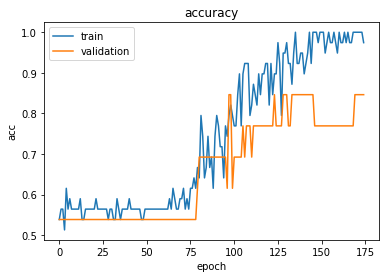

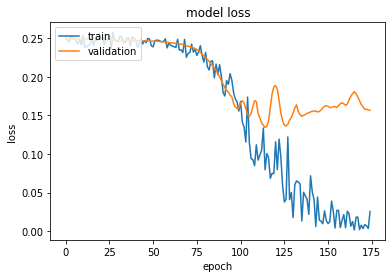

In [31]:
train_network()

In [29]:
evaluate_network()

Excelente Excelente produto muito bom correctly classified as Good 0.9996544122695923
Um ótimo investimento a um preço justo Produto de qualidade para o que se propõe a fazer ou seja para ser utilizada em ambiente doméstico cumpre o que promete e com um preço justo Mas não se engane ela é lenta como furadeira Caso queira furar aço muito espesso ou uma madeira muito dura melhor investir em brocas bem afiadas Como parafusadeira ela é ótima tem um excelente torque Só não entendo o porque na descrição do produto tem 10nm de torque enquanto que no manual indica que tem 8nm Perguntei à demeo o por que disso mas não obtive resposta apesar de terem dito que iriam avaliar isso Utilizo a parafusadeira em pinus e já fiz muita coisa com excelentes resultados correctly classified as Good 0.9965149164199829
Bom Parafusadeira boa para trabalhos pequenos uma vez que não utilizei para realizar trabalhos maiores O ponto forte é a bateria que é excelente e mantém a carga por muito tempo Estou utilizando 

0.7575757575757576
